In [2]:
import torch
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 150
f_path = "/System/Library/Fonts/Helvetica.ttc"
font_name = fm.FontProperties(fname=f_path).get_name()
rc('font', family=font_name, size=13)

from collections import defaultdict
import seaborn as sns

In [134]:
data_indices = [0,1,2,3,4]
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']
model_labels = ['Finetuned BERT', 'Finetuned S-BERT', 'BERT', 'S-BERT']

### User belief data

In [236]:
#from training set 
model_type = model_types[1] #fine-tuned S-BERT        

df_samples = []

for data_idx in range(0,5):
    df_sample = pd.read_pickle("../dataset/04_K-fold_dataset_nodup/df_train_idx%d.p"%(data_idx))
    df_sample = df_sample[~df_sample.duplicated()]
    df_samples.append(df_sample)

In [237]:
belief2vecs = {}
#belief to corresponding embedding vector

for i in range(5):
    with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(%d)_model(model_roberta-base_ft).p'%(i), 'rb') as f:
        belief2vec = pickle.load(f)
    
    belief2vecs[i] = belief2vec

### User belief sequence

In [248]:
data_idx = 0

user2beliefvecs = {}

df_ = df_samples[data_idx]

filtered_df = df_.groupby('username').filter(lambda x: len(x) > 20)
print("Number of unique users: %d"%(len(filtered_df['username'].unique())))


for g, dat in filtered_df.groupby('username'):
    dat = dat.sort_values(by='debate_date')
    user_beliefs = dat['belief_statement']
    belief_vecs = np.array([belief2vecs[data_idx][b] for b in user_beliefs])

    user2beliefvecs[g] = belief_vecs

Number of unique users: 1154


### Moving average

In [249]:
def gyration_radius(vecs):
    #vecs: numpy array of vectors. 
    mean_vec = vecs.mean(axis=0)
    diffs = vecs - mean_vec
    square = np.linalg.norm(diffs, axis=1)**2

    mean_square = square.sum()/len(square)
    rms = np.sqrt(mean_square)
    
    return rms

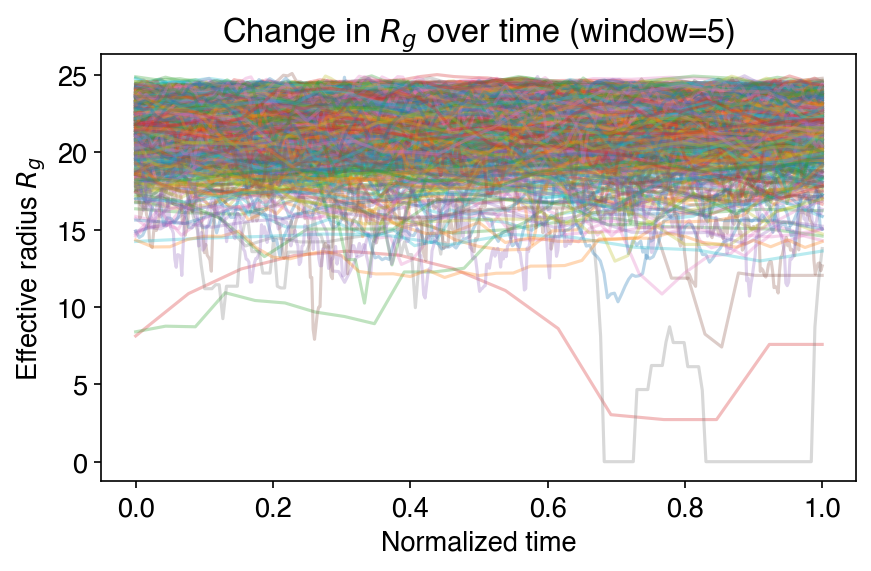

In [313]:
segment_radius_allusers = []

for user in user2beliefvecs:

    belief_records = user2beliefvecs[user]

    L = len(belief_records)

    w = 5

    segment_radius = [] 

    for i in range(w, L-w):
        x_min = max(0, i-w)
        x_max = min(L, i+w)

        segment = belief_records[x_min:x_max]    
        segment_radius.append(gyration_radius(segment))

    segment_radius_allusers.append(segment_radius)


plt.figure()
for rlist in segment_radius_allusers:

    x_norm = np.linspace(0, 1, len(rlist))

    plt.plot(x_norm, rlist, alpha=0.3)

plt.xlabel('Normalized time')
plt.ylabel(r'Effective radius $R_{g}$')
plt.title(r"Change in $R_g$ over time (window=%d)"%(w))
plt.tight_layout()

plt.savefig('../fig/effective_radius/Radius_over_time_(w=%d).pdf'%(w), transparent=True, bbox_inches='tight')

### Linear regression on radius over time

In [314]:
from sklearn.linear_model import LinearRegression

In [315]:
model = LinearRegression()

# Store slopes (coefficients)
slopes = []

for rlist in segment_radius_allusers:
    
    x_norm = np.linspace(0, 1, len(rlist)).reshape(-1,1)
    y = np.array(rlist)    
    model.fit(x_norm, y)
    
    # Store the slope (coefficient)
    slopes.append(model.coef_[0])

slopes = np.array(slopes)

In [316]:
sum(slopes>0), sum(slopes<0)

print(np.mean(slopes))

0.006251056307797658


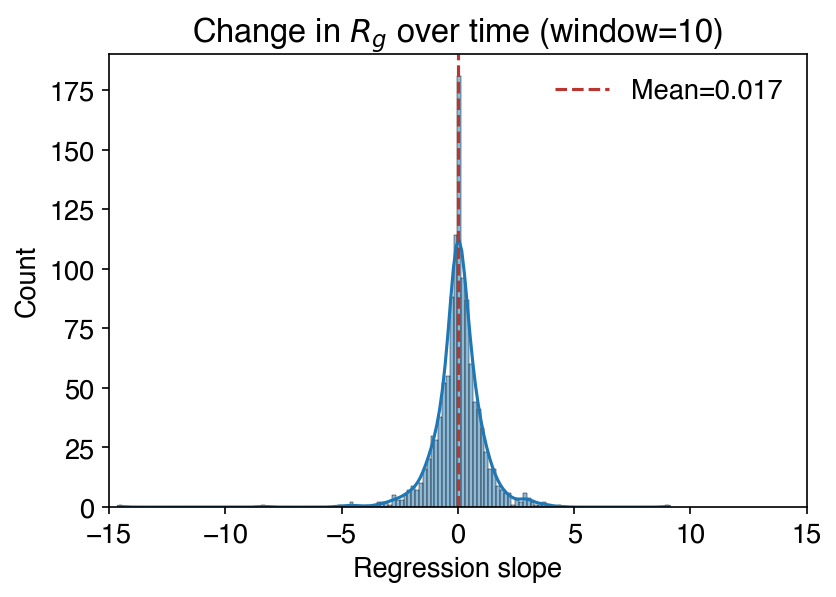

In [310]:
sns.histplot(slopes, kde=True)

#plt.xlim(-5,5)
plt.xlabel("Regression slope")
plt.title(r"Change in $R_g$ over time (window=%d)"%(w))
plt.axvline(x=np.mean(slopes), ls='--', color='#B93530', label='Mean=%.3f'%(np.mean(slopes)))
plt.xlim(-15,15)
plt.legend(frameon=False)

plt.savefig('../fig/effective_radius/Radius_vs_time_Regression_slope_(w=%d).pdf'%(w), transparent=True, bbox_inches='tight')